# Test sampling algorithms

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import torch
import zuko

import ment_torch as ment

In [2]:
plt.style.use("style.mplstyle")

## Create distribution

In [3]:
class RingDistribution:
    def __init__(self) -> None:
        self.ndim = 2

    def prob(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., 0]
        x2 = x[..., 1]
        log_prob = torch.sin(torch.pi * x1) - 2.0 * (x1**2 + x2**2 - 2.0) ** 2
        return torch.exp(log_prob)

    def prob_grid(
        self, shape: tuple[int], limits: list[tuple[float, float]]
    ) -> torch.Tensor:
        edges = [
            torch.linspace(limits[i][0], limits[i][1], shape[i] + 1)
            for i in range(self.ndim)
        ]
        coords = [0.5 * (e[:-1] + e[1:]) for e in edges]
        points = torch.stack(
            [c.ravel() for c in torch.meshgrid(*coords, indexing="ij")], axis=-1
        )
        values = self.prob(points)
        values = values.reshape(shape)
        return values, coords

In [4]:
ndim = 2
xmax = 3.0
dist = RingDistribution()

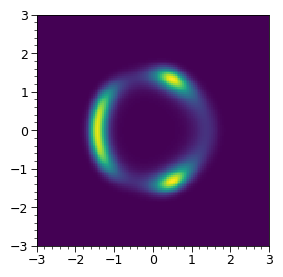

In [5]:
grid_limits = 2 * [(-xmax, xmax)]
grid_shape = (128, 128)
grid_values, grid_coords = dist.prob_grid(grid_shape, grid_limits)

fig, ax = plt.subplots(figsize=(3, 3))
ax.pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
plt.show()

## Sample

In [6]:
def plot_samples(x_pred: torch.Tensor) -> tuple:
    fig, axs = plt.subplots(ncols=2, figsize=(6.0, 2.75), sharex=True, sharey=True)
    hist, edges = np.histogramdd(x_pred.numpy(), bins=80, range=grid_limits)
    # hist = scipy.ndimage.gaussian_filter(hist, 1.0)
    axs[0].pcolormesh(edges[0], edges[1], hist.T)
    axs[1].pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
    axs[0].set_title("PRED", fontsize="medium")
    axs[1].set_title("TRUE", fontsize="medium")
    return fig, axs

In [7]:
def evaluate_sampler(sampler, size: int = 10_000):
    x_pred = sampler(dist.prob, size=size)
    return plot_samples(x_pred)

### Grid Sampling

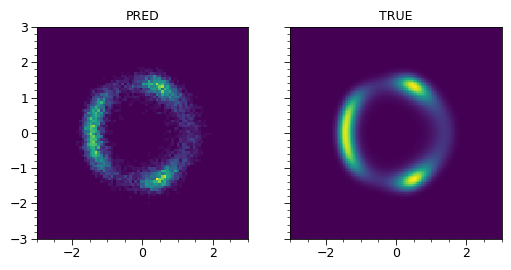

In [8]:
sampler = ment.GridSampler(limits=grid_limits, shape=grid_shape)

evaluate_sampler(sampler);

## Metropolis-Hastings

{'n_total_accepted': tensor(3557), 'n_total': 9990, 'acceptance_rate': tensor(0.3561), 'time': 0.06531906127929688, 'time_per_step': 6.531906127929688e-05}


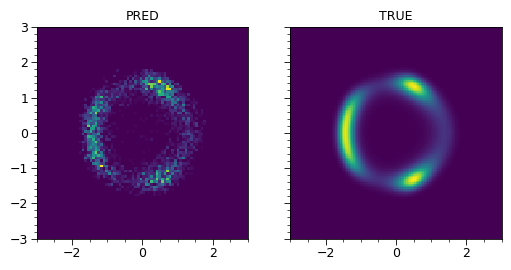

In [13]:
chains = 10
start = torch.randn((chains, ndim)) * 0.25
proposal_cov = torch.eye(ndim) * 0.25

sampler = ment.MetropolisHastingsSampler(
    ndim=ndim,
    start=start,
    proposal_cov=proposal_cov,
    verbose=0,
)

evaluate_sampler(sampler);

print(sampler.results)

### Hamiltonian Monte Carlo

100%|████████████████████████████████████████████████████████████████████████████████| 1010/1010 [00:01<00:00, 610.78it/s]


{'acceptance_rate': tensor(8.4400)}


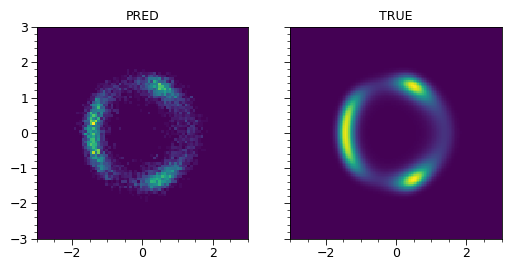

In [35]:
chains = 10
step_size = 0.21
steps_per_samp = 10

sampler = ment.HamiltonianMonteCarloSampler(
    ndim=ndim,
    start=torch.randn((chains, ndim)) * 0.25**2,
    step_size=step_size,
    steps_per_samp=steps_per_samp,
    burnin=10,
    verbose=1,
)
evaluate_sampler(sampler);

print(sampler.results)

## Normalizing Flow (NSF)

In [ ]:
flow = zuko.flows.NSF(features=ndim, transforms=3, hidden_features=[64] * 3)
flow = zuko.flows.Flow(flow.transform.inv, flow.base)
sampler = ment.FlowSampler(
    ndim=ndim,
    flow=flow,
    unnorm_matrix=None,
    train_kws=dict(
        iters=1000,
        batch_size=512,
    ),
)
evaluate_sampler(sampler);